# Constrained MPC

This notebook accompanies the paper [Learning Convex Optimization Models](https://web.stanford.edu/~boyd/papers/learning_copt_models.html).

In [2]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.notebook import tqdm

from cvxpylayers.torch import CvxpyLayer

import latexify
# latexify.latexify()
%matplotlib inline

torch.set_default_dtype(torch.double)

In [3]:
n = 10
m = 4
val_seed = 243
np.random.seed(0)
torch.manual_seed(0)
A_np = np.random.randn(n, n)
A_np /= np.max(np.abs(np.linalg.eig(A_np)[0]))
B_np = np.random.randn(n, m)

A = torch.tensor(A_np)
B = torch.tensor(B_np)
weights = torch.randn(n).abs()
weights_np = weights.numpy()
beta = 0.5
T = 5


def dynamics(xt, ut):
    return A @ xt + B @ ut + torch.randn(xt.shape)


def stage_cost(xt, ut):
    cost = 0.    
    return (weights*(xt.pow(2))).sum() + ut.pow(2).sum()

In [4]:
def construct_mpc_problem():
    x = cp.Parameter(n)
    states = [cp.Variable(n) for _ in range(T)]
    controls = [cp.Variable(m) for _ in range(T)]
    constraints = [states[0] == x, cp.norm(controls[0], 'inf') <= beta]
    objective = cp.sum(cp.multiply(weights_np, cp.square(states[0]))) + cp.sum_squares(controls[0])
    for t in range(1, T):
        objective += cp.sum(cp.multiply(weights_np, cp.square(states[t]))) + cp.sum_squares(controls[t])
        constraints += [states[t] == A_np @ states[t-1] + B_np @ controls[t-1]]
        constraints += [cp.norm(controls[t], 'inf') <= beta] 
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return CvxpyLayer(problem, variables=[controls[0]], parameters=[x])

mpc_policy = construct_mpc_problem()

In [5]:
def simulate(policy, n_iters=1000, seed=0):
    torch.random.manual_seed(seed)

    x0 = torch.randn(n)
    states = [x0]
    controls = []
    costs = []
    for t in tqdm(range(n_iters)):
        xt = states[-1]
        ut = policy(xt)[0]
        controls.append(ut)
        costs.append(stage_cost(xt, ut).item())
        states.append(dynamics(xt, ut))
    return states[:-1], controls, costs
    
states, controls, costs = simulate(mpc_policy)
scale = 0.31622776601
torch.manual_seed(1)
for control in controls:
    control.add_(scale*torch.randn(control.shape))
    control.clamp_(-beta, beta)


_, val_mpc_controls, val_mpc_costs = simulate(mpc_policy, seed=val_seed)
for control in val_mpc_controls:
    control.add_(scale*torch.randn(control.shape))
    control.clamp_(-beta, beta)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
def mse(preds, actual):
    preds = torch.stack(preds, dim=0)
    actual = torch.stack(actual, dim=0)
    return (preds - actual).pow(2).mean(axis=1).mean(axis=0).item()

In [8]:
_, true_copt_controls, _ = simulate(mpc_policy, seed=val_seed)
true_mse = mse(true_copt_controls, val_mpc_controls)
true_mse

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06556309899284204

In [9]:
def construct_agent_mpc_problem():
    x = cp.Parameter(n)
    weights = cp.Parameter(n, nonneg=True)
    states = [cp.Variable(n) for _ in range(T)]
    controls = [cp.Variable(m) for _ in range(T)]
    constraints = [states[0] == x, cp.norm(controls[0], 'inf') <= beta]
    objective = cp.sum(cp.multiply(weights, cp.square(states[0]))) + cp.sum_squares(controls[0])
    for t in range(1, T):
        objective += cp.sum(cp.multiply(weights, cp.square(states[t]))) + cp.sum_squares(controls[t])
        constraints += [states[t] == A_np @ states[t-1] + B_np @ controls[t-1]]
        constraints += [cp.norm(controls[t], 'inf') <= beta] 
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return CvxpyLayer(problem, variables=[controls[0]], parameters=[x, weights])

In [26]:
adp_policy = construct_agent_mpc_problem()



weights_tch = torch.ones(n, requires_grad=True)
state_feedback_policy = lambda x: adp_policy(x, weights_tch)

epochs = 200
val_losses = []
losses = []
with torch.no_grad():
    _, initial_preds, _ = simulate(state_feedback_policy, seed=val_seed)
    val_losses.append(mse(initial_preds, val_mpc_controls))
    print(val_losses[-1])
opt = torch.optim.Adam([weights_tch], lr=3e-4)

for epoch in range(epochs):
    print('Epoch: ', epoch)
    for xt, ut in tqdm(zip(states, controls)):
        opt.zero_grad()
        ut_hat = adp_policy(xt, weights_tch)[0]
        loss = (ut - ut_hat).pow(2).mean()
        loss.backward()
        losses.append(loss.item())
        opt.step()
    with torch.no_grad():
        weights_tch.data = weights_tch.relu()
        _, pred_ctrls, _ = simulate(state_feedback_policy, seed=val_seed)
        val_losses.append(mse(pred_ctrls, val_mpc_controls))
    print(val_losses[-1])

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07279813004930775
Epoch:  0


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07168520839854209
Epoch:  1


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07070054901184106
Epoch:  2


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06985309426136549
Epoch:  3


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06913012735995851
Epoch:  4


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06853588298631481
Epoch:  5


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06802612459939941
Epoch:  6


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06758999067931867
Epoch:  7


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06723112913100546
Epoch:  8


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06693438730326327
Epoch:  9


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06668483897297779
Epoch:  10


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06647700877857352
Epoch:  11


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06631417473217996
Epoch:  12


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06617063530247125
Epoch:  13


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06605359184342578
Epoch:  14


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06595756010929316
Epoch:  15


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06587642856371856
Epoch:  16


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06580937541050683
Epoch:  17


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06575306097492774
Epoch:  18


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06570345204505036
Epoch:  19


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06566081487161496
Epoch:  20


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06562037829513571
Epoch:  21


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.0655883253794554
Epoch:  22


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.0655582949891183
Epoch:  23


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.06553122305710292
Epoch:  24


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

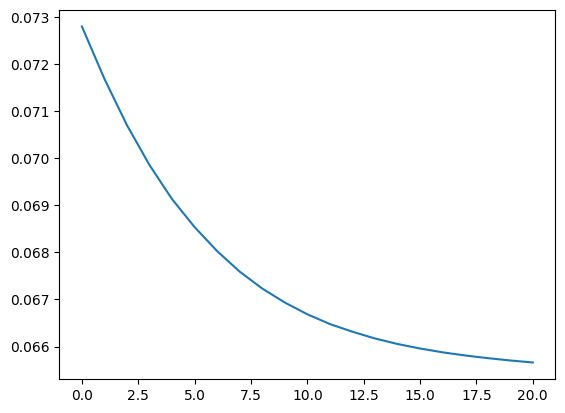

In [11]:
plt.plot(val_losses)

In [12]:
state_feedback_policy = lambda x: adp_policy(x, weights_tch)
agent_states, agent_controls, agent_costs = simulate(state_feedback_policy)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
weights_np

array([1.54099611, 0.29342891, 2.17878938, 0.56843128, 1.08452234,
       1.3985954 , 0.40334685, 0.83802633, 0.71925758, 0.40334352])

In [14]:
weights_tch.detach().numpy()

array([1.24219202, 0.20942078, 1.52288644, 0.5029243 , 0.65787073,
       1.32824706, 0.53741501, 0.8595692 , 0.7002981 , 0.76291338])

In [15]:
def plot_weights(w, h):
    fig = plt.figure()
    fig.set_size_inches((w, h))
    plt.plot(weights_tch.detach().numpy(), linestyle='-', color='k', label='learned')
    plt.plot(weights_np, linestyle='--', color='k', label='true')
    plt.xlabel(r'$i$')
    plt.ylabel(r'$\theta_i$')
    plt.legend()
    plt.tight_layout()

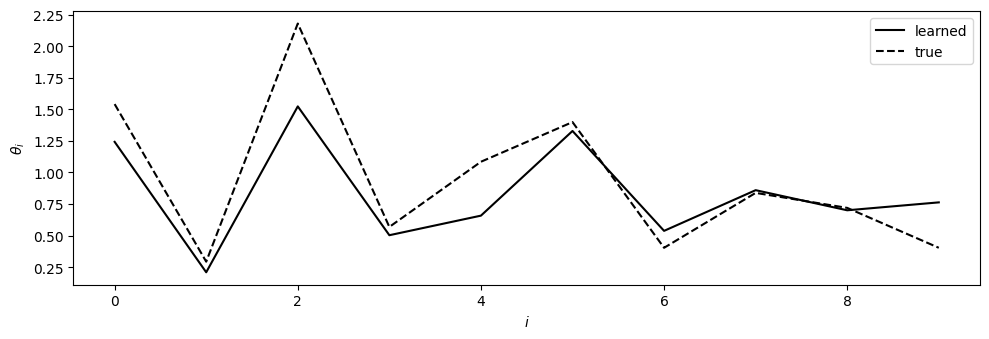

In [16]:
w, h = 10., 3.5
plot_weights(w, h)
plt.show()

### NN

In [17]:
class FF(torch.nn.Module):
    def __init__(self):
        super(FF, self).__init__()
        self.fc1 = torch.nn.Linear(in_features=n, out_features=n)
        self.fc2 = torch.nn.Linear(in_features=n, out_features=m)
        
    def forward(self, x):
        h1 = self.fc1(x).relu()
        return self.fc2(h1).clamp(-beta, beta)

In [18]:
torch.random.manual_seed(0)
ff = FF()


epochs = 100
nn_losses = []
val_nn_losses = []
opt = torch.optim.Adam(ff.parameters(), lr=3e-4)
for epoch in range(epochs):
    print('Epoch: ', epoch)
    for xt, ut in tqdm(zip(states, controls)):
        opt.zero_grad()
        ut_hat = ff(xt)
        loss = (ut - ut_hat).pow(2).mean()
        loss.backward()
        nn_losses.append(loss.item())
        opt.step()
    _, val_preds, _ = simulate(lambda x: [ff(x)], seed=val_seed)
    with torch.no_grad():
        val_nn_losses.append(mse(val_preds, val_mpc_controls))
    print(val_nn_losses[-1])

Epoch:  0


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.13339589609580554
Epoch:  1


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.10389791059464044
Epoch:  2


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.09214982051856394
Epoch:  3


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.08513929878756676
Epoch:  4


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.08075310366437276
Epoch:  5


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07787017943873682
Epoch:  6


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07605946398022072
Epoch:  7


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07487401171014839
Epoch:  8


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07407952477298235
Epoch:  9


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07339378753039304
Epoch:  10


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07283926367302487
Epoch:  11


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07241925466432736
Epoch:  12


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07217880787019118
Epoch:  13


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07189581091504935
Epoch:  14


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07166553371505356
Epoch:  15


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07152112609879913
Epoch:  16


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07142861771329834
Epoch:  17


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07137997291945086
Epoch:  18


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.0713085055667554
Epoch:  19


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07125589521447051
Epoch:  20


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07122171287531583
Epoch:  21


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07120333459446208
Epoch:  22


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07119798292377454
Epoch:  23


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07119400426906528
Epoch:  24


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.071174248060433
Epoch:  25


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07118315220585092
Epoch:  26


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07114099424060914
Epoch:  27


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07108837434405992
Epoch:  28


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07106249328043404
Epoch:  29


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07104736387857345
Epoch:  30


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07103493313017685
Epoch:  31


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.0709843506512692
Epoch:  32


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07099685958140305
Epoch:  33


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07093052585121805
Epoch:  34


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07092634374994451
Epoch:  35


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07092785991672138
Epoch:  36


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07089864863361936
Epoch:  37


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07090757594714471
Epoch:  38


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07088769371748217
Epoch:  39


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07090416923286348
Epoch:  40


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07088230900629053
Epoch:  41


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07087425987788351
Epoch:  42


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07085705611486895
Epoch:  43


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07085811102814209
Epoch:  44


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07085048982410792
Epoch:  45


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07085929188123474
Epoch:  46


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07087522925117082
Epoch:  47


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07087674469694992
Epoch:  48


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07087865477468452
Epoch:  49


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07088750861696465
Epoch:  50


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07089805057893364
Epoch:  51


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07090142153276634
Epoch:  52


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07091543062245363
Epoch:  53


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.0709369781561067
Epoch:  54


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07095748948776649
Epoch:  55


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07097404469335299
Epoch:  56


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07099107295808361
Epoch:  57


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07099122528714887
Epoch:  58


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07100022093313663
Epoch:  59


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07100519695990033
Epoch:  60


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07099751845305916
Epoch:  61


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.0710175587759661
Epoch:  62


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07102265771959748
Epoch:  63


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07105257250953952
Epoch:  64


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.0710410480408479
Epoch:  65


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07103933222225643
Epoch:  66


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07109160995094849
Epoch:  67


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.0710957164838329
Epoch:  68


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07112572752832715
Epoch:  69


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07112900294754514
Epoch:  70


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07111945124290961
Epoch:  71


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.0711613622866763
Epoch:  72


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.0711754848022884
Epoch:  73


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07119704697790155
Epoch:  74


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07120896986614622
Epoch:  75


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07121952887175914
Epoch:  76


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07123513564022294
Epoch:  77


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07123774202683651
Epoch:  78


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07125034778880064
Epoch:  79


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07122057805078107
Epoch:  80


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07123184721964813
Epoch:  81


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07122475026251586
Epoch:  82


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07122299917345366
Epoch:  83


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07120942228697202
Epoch:  84


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07120794973570305
Epoch:  85


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07121594594775396
Epoch:  86


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07123199183146829
Epoch:  87


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07122959127930989
Epoch:  88


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07123480836497757
Epoch:  89


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07122178857934186
Epoch:  90


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.0712315125459263
Epoch:  91


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07122879697427215
Epoch:  92


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07123227888805962
Epoch:  93


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07123411307902236
Epoch:  94


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.0712438049474701
Epoch:  95


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.0712266114237041
Epoch:  96


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07123968044943242
Epoch:  97


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07123779364801626
Epoch:  98


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07124489945545202
Epoch:  99


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07125979556040327


In [19]:
val_losses[-1]

0.06566081487161496

In [20]:
val_nn_losses[-1]

0.07125979556040327

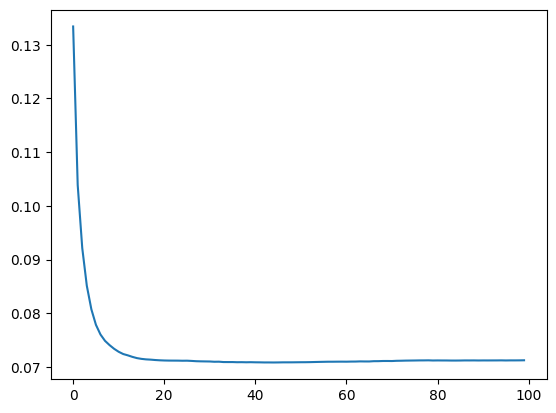

In [21]:
plt.plot(val_nn_losses)

In [22]:
def plot_losses(w, h):
    fig = plt.figure()
    fig.set_size_inches((w, h))
    plt.axhline(val_nn_losses[-1], color='k', linestyle='-.', label='NN')    
    plt.plot(np.arange(len(val_losses)) + 1, val_losses, color='k', label='COM')
    plt.axhline(true_mse, color='k', linestyle='--', label='true')
    plt.xticks([1, 5, 10, 15, 20])
    plt.xlabel('iteration')
    plt.ylabel('validation loss')
    plt.legend(loc='upper right')
    plt.tight_layout()

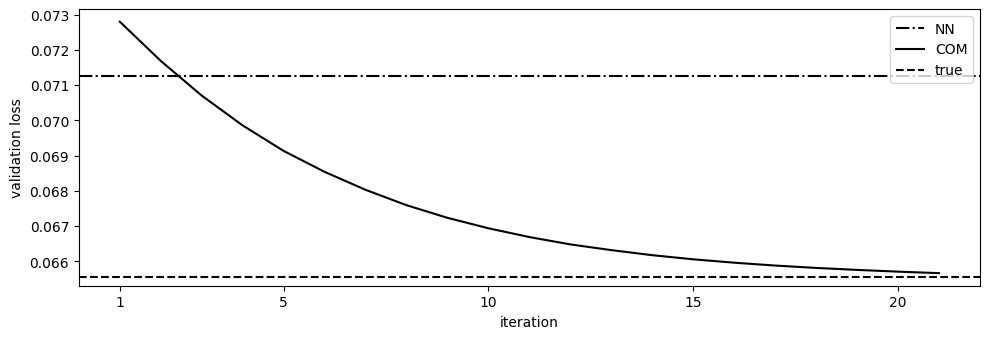

In [23]:
w, h = 10, 3.5
plot_losses(w, h)
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


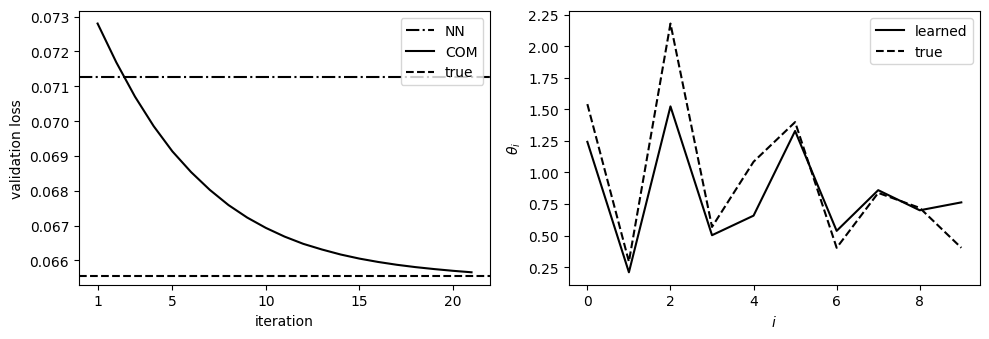

In [25]:
%load_ext autoreload
%autoreload 2

import latexify
# latexify.latexify()

w = 10
h = 3.5

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(w, h)

ax[1].plot(weights_tch.detach().numpy(), linestyle='-', color='k', label='learned')
ax[1].plot(weights_np, linestyle='--', color='k', label='true')
ax[1].set_xlabel(r'$i$')
ax[1].set_ylabel(r'$\theta_i$')
ax[1].set_xticks([0, 2,4, 6, 8])
ax[1].legend()
    
ax[0].axhline(val_nn_losses[-1], color='k', linestyle='-.', label='NN')
ax[0].plot(np.arange(len(val_losses)) + 1, val_losses, color='k', label='COM')
ax[0].axhline(true_mse, color='k', linestyle='--', label='true')
ax[0].set_xticks([1, 5, 10, 15, 20])
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('validation loss')
ax[0].legend(loc='upper right')

plt.tight_layout()
plt.show()